In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torchtext
from torchtext import data
import spacy
import matplotlib.pyplot as plt
import torch.nn.utils.rnn as tnt
import readline

In [2]:
seed = 0
torch.manual_seed(seed)
train_s = 0.64
val_s = 0.16
test_s = 0.2
OF_len = 50
batch_size = 64
lr = 0.001
epochs = 25
num_filt = 50
k = [2,4]
net = "CNN" # Can be "RNN" or "baseline"
OF = False # Trains on overfit data instead of train data if True

In [3]:
dt = pd.read_csv("./data/data.tsv", sep='\t') # Load data
# Separate objective and subjective data 
obj = dt[dt['label']==0]
sub = dt[dt['label']==1]
# Length of each train, test, and validation set
objTrain_len = int(train_s * len(obj))
objVal_len = int(val_s * len(obj))
objTest_len = int(test_s * len(obj))
subTrain_len = int(train_s * len(sub))
subVal_len = int(val_s * len(sub))
subTest_len = int(test_s * len(sub))
# Split objective and subjective sets
objTrain = obj[:objTrain_len]
objVal = obj[objTrain_len:objTrain_len+objVal_len]
objTest = obj[objTrain_len+objVal_len:objTrain_len+objVal_len+objTest_len]
objOF = obj[:int(OF_len/2)]
subTrain = sub[:subTrain_len]
subVal = sub[subTrain_len:objTrain_len+objVal_len]
subTest = sub[subTrain_len+subVal_len:subTrain_len+subVal_len+subTest_len]
subOF = sub[:int(OF_len/2)]
# Append corresponding objective and subjective sets
train_set = pd.concat([objTrain,subTrain],ignore_index=True)
val_set = pd.concat([objVal,subVal],ignore_index=True)
test_set = pd.concat([objTest,subTest],ignore_index=True)
OF_set = pd.concat([objOF,subOF],ignore_index=True)
# Save train, validation, test sets as TSV files
train_set.to_csv("./data/train.tsv",index=False,sep='\t')
val_set.to_csv("./data/validation.tsv",index=False,sep='\t')
test_set.to_csv("./data/test.tsv",index=False,sep='\t')
OF_set.to_csv("./data/overfit.tsv",index=False,sep='\t')
# Print counts per class per set
print("Training Set")
print(train_set['label'].value_counts().to_string())
print("Validation Set")
print(val_set['label'].value_counts().to_string())
print("Test Set")
print(test_set['label'].value_counts().to_string())
print("Overfit Set")
print(OF_set['label'].value_counts().to_string())

Training Set
1    3200
0    3200
Validation Set
1    800
0    800
Test Set
1    1000
0    1000
Overfit Set
1    25
0    25


In [4]:
# Tells torchtext how each column in the TSV file will be processed when passed into the data.TabularDataset object
TEXT = data.Field(sequential=True,lower=True, tokenize='spacy', include_lengths=True)
LABELS = data.Field(sequential=False, use_vocab=False)
# Load the train, validation, and test datasets to become datasets 
train_data, val_data, test_data = data.TabularDataset.splits(
    path='data/', train='train.tsv', validation='validation.tsv', test='test.tsv', format='tsv', skip_header=True, fields=[('text', TEXT), ('label', LABELS)])
# Create an object that can be enumerated to be used in the training loops - these are the objects that produce each batch in the training loop.
train_iter, val_iter, test_iter = data.BucketIterator.splits(
    (train_data, val_data, test_data), batch_sizes=(batch_size, batch_size, batch_size), sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)
# Vocab object will contain the index (word token) for each unique word in the data set
TEXT.build_vocab(train_data, val_data, test_data)
# Download and load the vectors that are downloaded into the vocab object
TEXT.vocab.load_vectors(torchtext.vocab.GloVe(name='6B', dim=100))
vocab = TEXT.vocab
print("Shape of Vocab:",TEXT.vocab.vectors.shape)

C:\Users\esmat\anaconda3\envs\ece324\lib\site-packages\torchtext\data\field.py:150: UserWarning: Field class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)
C:\Users\esmat\anaconda3\envs\ece324\lib\site-packages\torchtext\data\example.py:68: UserWarning: Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('Example class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.', UserWarning)
C:\Users\esmat\anaconda3\envs\ece324\lib\site-packages\torchtext\data\example.py:78: UserWarning: Example class will be retired in the 0.8.0 release and moved to to

Shape of Vocab: torch.Size([21105, 100])


In [5]:
overfit_data = data.TabularDataset(
    path='data/overfit.tsv', format='tsv', skip_header=True, fields=[('text', TEXT), ('label', LABELS)])
overfit_iter = data.BucketIterator(
    overfit_data, len(overfit_data), sort_key=lambda x: len(x.text), device=None, sort_within_batch=True, repeat=False)

In [6]:
class Baseline(nn.Module):
    def __init__(self, vocab, embedding_dim=100):
        super(Baseline, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.fc = nn.Linear(embedding_dim, 1)
    def forward(self, x, lengths=None):
        # x = [sentence, length, batch size]
        embedded = self.embedding(x)
        average = embedded.mean(0) # [sentence length, batch size, embedding_dim]
        output = self.fc(average).squeeze(1)
        # Using the BCEWithLogitsLoss loss function performs the sigmoid function *as well* as well as the binary cross entropy loss computation (these are combined for numerical stability)
        return torch.sigmoid(output)

In [7]:
class CNN(nn.Module):
    def __init__(self, vocab, n_filters, filter_sizes, embedding_dim=100):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.conv1 = nn.Conv2d(1,n_filters,kernel_size=(filter_sizes[0],embedding_dim))
        self.conv2 = nn.Conv2d(1,n_filters,kernel_size=(filter_sizes[1],embedding_dim))
        self.fc = nn.Linear(embedding_dim,1)
    def forward(self, x, lengths=None):
        embedded = self.embedding(x)
        # NCHW formatting
        embedded = embedded.permute(1,0,2)
        embedded = embedded.unsqueeze(1)
        x_1 = F.relu(self.conv1(embedded))
        x_2 = F.relu(self.conv2(embedded))
        self.pool_1 = nn.MaxPool2d(kernel_size=(x_1.shape[2],1))
        self.pool_2 = nn.MaxPool2d(kernel_size=(x_2.shape[2],1))
        x_1 = self.pool_1(x_1)
        x_2 = self.pool_2(x_2)
        x = torch.cat((x_1,x_2),1).squeeze(2).squeeze(2)
        x = self.fc(x)
        return torch.sigmoid(x)

In [8]:
class RNN(nn.Module):
    def __init__(self,vocab, hidden_dim=100, embedding_dim=100):
        super(RNN, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(vocab.vectors)
        self.net = nn.GRU(embedding_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x, lengths=None):
        x = self.embedding(x)
        x = tnt.pack_padded_sequence(x,lengths)
        y, x = self.net(x)
        x = self.fc(x)
        return torch.sigmoid(x)

In [9]:
def accuracy(model, iterator):
    total_corr = 0
    for batch in iterator:
        batch_inputs, batch_input_lengths = batch.text
        batch_labels = batch.label
        index = 0
        predictions = model(batch_inputs, batch_input_lengths)
        for c in predictions.flatten():
            if (c.item()>0.5):
                r=1.0
            else:
                r=0.0
            if r==batch_labels[index].item():
                total_corr += 1
            index += 1
    return float(total_corr)/len(iterator.dataset)

C:\Users\esmat\anaconda3\envs\ece324\lib\site-packages\torchtext\data\batch.py:23: UserWarning: Batch class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.
  warnings.warn('{} class will be retired in the 0.8.0 release and moved to torchtext.legacy. Please see 0.7.0 release notes for further information.'.format(self.__class__.__name__), UserWarning)


Epoch: 1 Training Loss: 0.63 Training Accuracy 0.88  Validation Loss: 0.58 Validation Accuracy 0.86
Epoch: 2 Training Loss: 0.57 Training Accuracy 0.91  Validation Loss: 0.56 Validation Accuracy 0.89
Epoch: 3 Training Loss: 0.55 Training Accuracy 0.92  Validation Loss: 0.56 Validation Accuracy 0.89
Epoch: 4 Training Loss: 0.55 Training Accuracy 0.94  Validation Loss: 0.56 Validation Accuracy 0.90
Epoch: 5 Training Loss: 0.54 Training Accuracy 0.95  Validation Loss: 0.55 Validation Accuracy 0.90
Epoch: 6 Training Loss: 0.54 Training Accuracy 0.95  Validation Loss: 0.55 Validation Accuracy 0.91
Epoch: 7 Training Loss: 0.53 Training Accuracy 0.96  Validation Loss: 0.55 Validation Accuracy 0.90
Epoch: 8 Training Loss: 0.53 Training Accuracy 0.96  Validation Loss: 0.55 Validation Accuracy 0.91
Epoch: 9 Training Loss: 0.53 Training Accuracy 0.97  Validation Loss: 0.55 Validation Accuracy 0.91
Epoch: 10 Training Loss: 0.52 Training Accuracy 0.96  Validation Loss: 0.55 Validation Accuracy 0.90

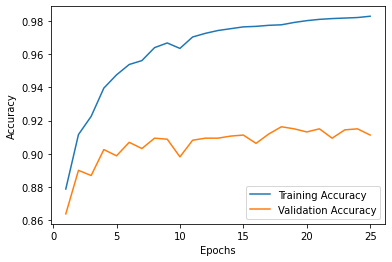

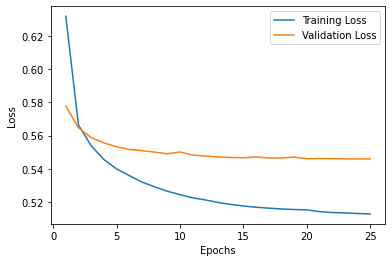

In [10]:
if net=="baseline":
    model = Baseline(vocab)
elif net=="CNN":
    model = CNN(vocab, num_filt, k)
else:
    model = RNN(vocab)
if OF:
    t_iter = overfit_iter
else:
    t_iter = train_iter
optimizer = torch.optim.Adam(model.parameters(),lr) 
loss_fcn = nn.BCEWithLogitsLoss()
loss_train, loss_val, acc_train, acc_val = [], [], [], []
# Training loop
for e in range(epochs):
    running_loss = 0
    batches = 0
    for i, train_batch in enumerate(t_iter):
        train_batch_inputs, train_batch_input_lengths = train_batch.text
        train_batch_labels = train_batch.label
        optimizer.zero_grad()
        train_predict = model(train_batch_inputs, train_batch_input_lengths)
        train_loss = loss_fcn(train_predict.squeeze(), train_batch_labels.float())
        train_loss.backward()
        optimizer.step()
        running_loss += train_loss.item()
        batches+=1
    train_acc = accuracy(model,t_iter)
    acc_train.append(train_acc)
    loss_train.append(running_loss/batches)
    running_loss = 0
    batches = 0
    for i, val_batch in enumerate(val_iter):
        val_batch_inputs, val_batch_input_lengths = val_batch.text
        val_batch_labels = val_batch.label
        val_predict = model(val_batch_inputs, val_batch_input_lengths)
        val_loss = loss_fcn(val_predict.squeeze(), val_batch_labels.float())
        running_loss += val_loss.item()
        batches += 1
    val_acc = accuracy(model,val_iter)
    acc_val.append(val_acc)
    loss_val.append(running_loss/batches)
    print(f"Epoch: {e+1} Training Loss: {loss_train[-1]:.2f} Training Accuracy {train_acc:.2f}  Validation Loss: {loss_val[-1]:.2f} Validation Accuracy {val_acc:.2f}")

# Test accuracy and loss    
for i, test_batch in enumerate(test_iter):
    test_batch_inputs, test_batch_input_lengths = test_batch.text
    test_batch_labels = test_batch.label
    test_predict = model(test_batch_inputs, test_batch_input_lengths)
    test_loss = loss_fcn(test_predict.squeeze(), test_batch_labels.float())
    running_loss += test_loss.item()
    batches += 1
test_acc = accuracy(model,test_iter)
test_loss = running_loss/batches
print(f"\nTest Loss: {test_loss:.2f} Test Accuracy {test_acc:.2f}")

# Accuracy and loss plots
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.plot(list(range(1,epochs+1)),acc_train,label="Training Accuracy")
plt.plot(list(range(1,epochs+1)),acc_val,label="Validation Accuracy")
plt.legend()
plt.show()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(list(range(1,epochs+1)),loss_train,label="Training Loss")
plt.plot(list(range(1,epochs+1)),loss_val,label="Validation Loss")
plt.legend()
plt.show()

In [11]:
# torch.save(model,'./model_baseline.pt')
# torch.save(model,'./model_cnn.pt')
# torch.save(model,'./model_rnn.pt')

In [ ]:
def tokenizer(text):
    spacy_en = spacy.load('en')
    return [tok.text for tok in spacy_en(text)]

def classify(output):
    if output > 0.5:
        return "subjective"
    return "objective"

baseline = torch.load("./model_baseline.pt")
cnn = torch.load("./model_cnn.pt")
rnn = torch.load("./model_rnn.pt")
while True:
    sentence = input("Enter a sentence\n")
    tokens = tokenizer(sentence)
    token_ints = [vocab.stoi[tok] for tok in tokens]
    token_tensor = torch.LongTensor(token_ints).view(-1, 1)
    if token_tensor.shape[1]==1 and token_tensor.shape[0] < 4:
        padding = torch.zeros((4,1), dtype=torch.long)
        padding[:token_tensor.shape[0],:] = token_tensor
        token_tensor = padding
    lengths = torch.Tensor([len(token_ints)])
    baseline_output = baseline(token_tensor,lengths).item()
    baseline_label = classify(baseline_output)
    cnn_output = cnn(token_tensor,lengths).item()
    cnn_label = classify(cnn_output)
    rnn_output = rnn(token_tensor,lengths).item()
    rnn_label = classify(rnn_output)
    print(f'\nModel baseline: {baseline_label} ({baseline_output:.3f})')
    print(f'Model rnn: {rnn_label} ({rnn_output:.3f})')
    print(f'Model cnn: {cnn_label} ({cnn_output:.3f})\n')